In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import pandas as pd
column_to_predict = 'transcriptConsumer_en'
important_cols = ['conversationId', 'firstConversation', 'transcriptAll', 'transcriptConsumer', 'transcriptConsumer_en', 'classification', 'classification 2', 'despair',	'loneliness', 'emotional overflow',	'self blame',	'anxiety',	'distrust / confusion',	'new assault / new exposure',	'level of suicide/ level of risk',	'obligation to report occording law',	'support for support circuls']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/nlp-projects/inputs/he/clean_1.8.23_19.9.23.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def translate_columns(filtered_df, columns_to_translate, chunk_size, src='he', dest='en'):
    # Initialize the Translator object
    translator = Translator()

    # Function to translate text
    def translate_text(text):
        if pd.isna(text):
            return None  # Return None if text is NaN
        try:
            # Split text into chunks with a word count greater than 600
            chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
            translated_chunks = []
            # Translate each chunk
            for chunk in chunks:
                result = translator.translate(chunk, src=src, dest=dest)
                translated_chunks.append(result.text)
            # Concatenate translated chunks
            translated_text = ' '.join(translated_chunks)
            return translated_text
        except Exception as e:
            #print(f"Error translating text: '{text}'. Error: {e}")
            return "Translation failed"

    # Translate each specified column
    for column in columns_to_translate:
        # Apply translation to each row in the column
        filtered_df[f'{column}_en'] = filtered_df[column].apply(translate_text)

    return filtered_df

In [ ]:
df = pd.read_excel(drive_path)
df.shape

(1037, 20)

In [ ]:
!pip install googletrans==3.1.0a0
from googletrans import Translator

In [ ]:
df = translate_columns(df, ['transcriptConsumer'], 600, src='he', dest='en')
df.to_excel('/content/drive/My Drive/nlp-projects/inputs/en/clean_translated_1.8.23_19.9.23.xlsx', index=False)

In [ ]:
df[column_to_predict] = df[column_to_predict].astype(str)

<Axes: ylabel='count'>

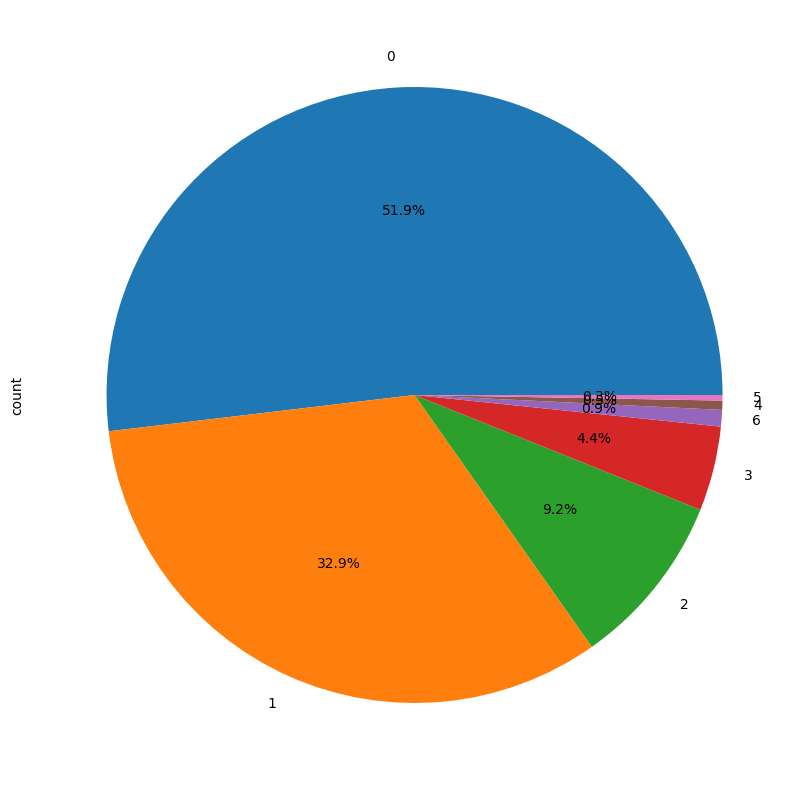

In [ ]:
df['classification'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [ ]:
label_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    4: 1,
    5: 1,
    6: 1
}

# Create a new column by mapping the original labels to the new labels
df['new_classification'] = df['classification'].map(label_mapping)

<Axes: ylabel='count'>

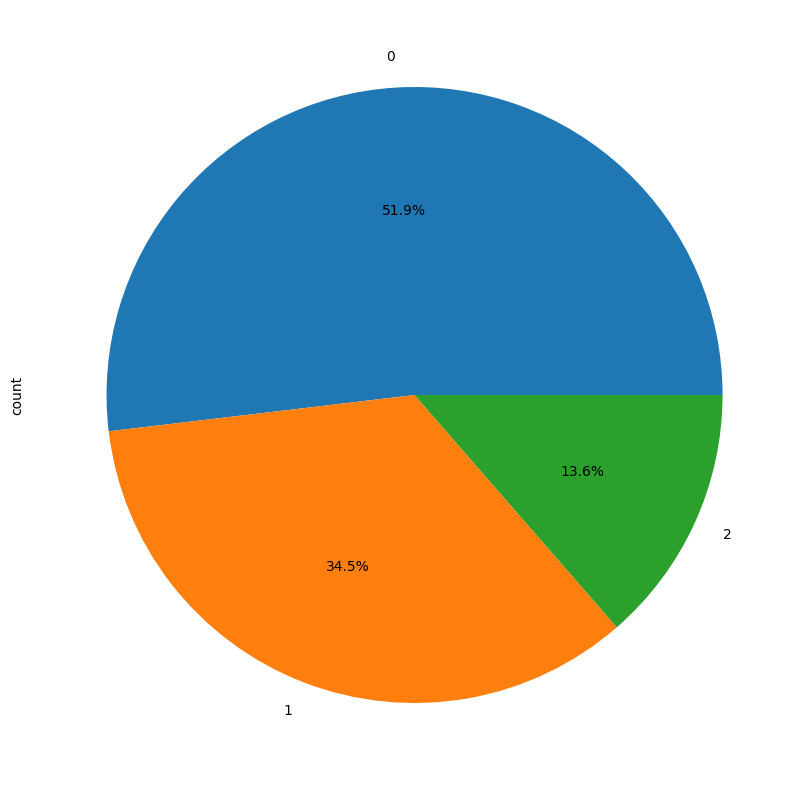

In [ ]:
df['new_classification'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [ ]:
drive_path_he = '/content/drive/My Drive/nlp-projects/inputs/he/clean_1.8.23_19.9.23.xlsx'

In [ ]:
df.to_excel(drive_path_he)

In [ ]:
!pip install accelerate -U
!pip install torch transformers -U
!pip install transformers[torch]

In [ ]:
model_name = 'bert-base-multilingual-cased'

In [ ]:
drive_path_he = '/content/drive/My Drive/nlp-projects/inputs/he/clean_1.8.23_19.9.23.xlsx'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_excel(drive_path_he)
df.shape

(1037, 21)

In [ ]:
df[{column_to_predict}] = df[{column_to_predict}].astype(str)

TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [ ]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize the texts
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

# Tokenize the texts in the dataframe
tokenized_texts = df[{column_to_predict}].apply(lambda x: tokenize_function(x))


# Create a Custom Dataset Class

In [ ]:
import torch


In [ ]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.long)
        return item

In [ ]:
# Create the dataset
texts = df[{column_to_predict}].tolist()
labels = df['new_classification'].tolist()
dataset = CustomDataset(texts, labels, tokenizer, max_length=512)

In [ ]:
texts[0]

In [ ]:
num_labels = len(set(labels))
num_labels

In [ ]:
!pip install scikit-learn

In [ ]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

# Split the dataset into train and validation sets
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = list(splitter.split(texts, labels))[0]

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


# Define the Model and Training Arguments

In [ ]:
!pip install tensorboard


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    # Calculate weighted precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    # Create a dictionary to store the overall metrics
    metrics = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    return metrics

"""
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average=None, labels=labels)
    acc = accuracy_score(labels, preds)

    # Create a dictionary to store metrics for each label
    metrics = {
        'accuracy': acc,
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'support': support.tolist()
    }
    print("Metrics:", metrics)
    return metrics
    """
"""
    print(labels)
    # Print metrics for each label
    for i, label in enumerate(labels):
        print(f"Metrics for {label}:")
        print(f"  Precision: {metrics['precision'][i]}")
        print(f"  Recall: {metrics['recall'][i]}")
        print(f"  F1 Score: {metrics['f1'][i]}")
        print(f"  Support: {metrics['support'][i]}")

    return metrics
    """

In [ ]:
# Custom Trainer class to log loss values
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_loss = []
        self.eval_loss = []

    def log(self, logs: dict):
        super().log(logs)
        if 'loss' in logs:
            self.train_loss.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_loss.append(logs['eval_loss'])

In [ ]:

from transformers import EarlyStoppingCallback, IntervalStrategy

# Initialize the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, hidden_dropout_prob=0.3)  # Increase dropout probability

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,  # Accumulate gradients
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    metric_for_best_model='eval_accuracy',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="tensorboard",
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Initialize the optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_steps = len(train_loader) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=train_steps)

# Initialize the Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)]
)


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# Initialize a list to store metrics
metrics_history = []
# Track the best accuracy and corresponding epoch
best_accuracy = 0
best_epoch = -1
best_metrics = None

# Train the model and collect metrics for each epoch
for epoch in range(training_args.num_train_epochs):
    print(f"Training Epoch: {epoch + 1}")  # Debug: Print current epoch
    trainer.train()
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)  # Debug: Print evaluation results
    metrics_history.append(eval_results)

        # Check for the best accuracy
    if eval_results['eval_accuracy'] > best_accuracy:
        best_accuracy = eval_results['eval_accuracy']
        best_epoch = epoch + 1
        best_metrics = eval_results


In [ ]:
print("Accuracy of the best model:", eval_results['eval_accuracy'])
print(f"Best Accuracy: {best_accuracy} at epoch {best_epoch}")

In [ ]:
best_accuracy = format(eval_results['eval_accuracy'],".2f")
print(best_accuracy)

In [ ]:
import matplotlib.pyplot as plt

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(trainer.train_loss, label='Training Loss')
plt.plot(trainer.eval_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.show()

In [ ]:
model_path = f'/content/drive/My Drive/nlp-projects/models/he/{model_name}-classify-3-classes-{best_accuracy}'

In [ ]:
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Load the model

In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
model_path = f'/content/drive/My Drive/nlp-projects/models/he/bert-base-multilingual-cased-classify-3-classes-0-77'

In [ ]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
\from transformers import EarlyStoppingCallback, IntervalStrategy
import torch

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

model.eval()

In [ ]:
def predict_single_text(single_text):

  # Tokenize the text
  inputs = tokenizer(single_text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

  # Move model to device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Move inputs to the same device as the model
  inputs = {key: val.to(device) for key, val in inputs.items()}

  model.eval()
  with torch.no_grad():
      outputs = model(**inputs)
      logits = outputs.logits
      predicted_class_id = torch.argmax(logits, dim=-1).item()
  return predicted_class_id


In [ ]:
text = """
היי אני לא יודעת אם לפנות אליכם או לא. לפני מספר ימים עברתי משהו לא נעים, ידיד של חברה שלי שהיה אמור להקפיץ אותי לבית, הוא לקח אותי לבית שלו, כל הדרך הבהרתי שאני לא אכנס אליו לבית ושאני לא מעוניינת. הגענו למקום הוא רצה שאכנס וטען שרק יאכל משהו ויקח אותי לבית, כל הזמן שהיינו אצלו הוא רצה שאקשיב לו, ניסה לגעת בי, לחבק אותי, אמר לי ללכת לישון ונשכב לידי מבלי שאני רוצה. לבסוף כעסתי, דרשתי שלא יתקרב אלי ואחרי זמן ארוך מצאתי דרך לחזור לבית. כן
"""
# Make prediction for the single text
predicted_class_id = predict_single_text(text)
predicted_class_id


In [ ]:
text = """
'שלום
הבת שלי בת 16 ושיתפה אותי היום שהיא עברה פגיעה מינית עי ילד מהכיתה כשהייתה בכיתה ד
היא זוכרת את זה
זוכרת שכאב לה
ולא זוכרת מעבר לזה. אציין שהבת שלי על הרצף בתפקוד גבוה וכבר לפני שנתיים בטיפול נזכרה שעברה הטרדה בבית ספר על ידי אותו ילד. אך לא אונס.

האם היום, ככ הרבה זמן אחרי, ניתן לבצע בדיקה גניקולוגית כדי לדעת שהיא אכן נאנסה?'
'נכון'
'אני דיי המומה'
'נכון
היא גם הייתה מטופלת פסיכולוגית אז
וזה אף פעם לא עלה
אני לא מבינה איך'
'אני מאמינה לבת שלי
אבל חייבת לדעת אם זה קרה או לא
ברור שמבחינת טיפול, היא מטופלת כי גם אם זה לא קרה ככה בדיוק, וזה מה שהיא מרגישה, זה מצריך טיפול
אבל אני רוצה לדעת אם זה קרה
כי אם כן
אני חייבת לפעול מול אותו ילד'
'יש אפשרות לדעת אחרי ככ הרבה זמן?'
'ברור'
'את הספקות אני לא חולקת איתה
אבל אני מרגישה ממש צורך לפנות לאמא של הילד
אני ממש כועסת
פתאום נקודות מתחברות לי'
'מבנימינה'
'תודה
אקרא'
'ועל אמא שלו'
'אני נזכרת שהיא תמיד רצתה שיפגשו אצלו
ושהבת שלי הייתה חוזרת משם עם מתנות
שגם אז נראו לי מוגזמות וביקשתי שיפסיק
עכשיו אני חוששת שקנו את השתיקה שלה

הילד באמת עזב למסגרת מיוחדת סביב כיתה ד או ה'
'תודה רבה!'
"""
text = text.replace("'", "")
predicted_class_id = predict_single_text(text)
predicted_class_id

In [ ]:
import pandas as pd

drive_path = '/content/drive/My Drive/nlp-projects/inputs/he/clean_1.8.23_19.9.23.xlsx'
df = pd.read_excel(drive_path)

In [ ]:
df = pd.read_excel(drive_path)
df.shape

In [ ]:
df['classification'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [ ]:
df['new_classification'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [ ]:
filtered_df = df[df['new_classification'] == 1]

In [ ]:
filtered_df['classification'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [ ]:
new_class_mapping = {
    1: 1,
    4: 3,
    5: 3,
    6: 3
}

filtered_df['new_class'] = filtered_df['classification'].map(new_class_mapping)

In [ ]:
filtered_df['new_class'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [ ]:
labels = filtered_df['new_class'].tolist()
texts = filtered_df[{column_to_predict}].tolist()
dataset = CustomDataset(texts, labels, tokenizer, max_length=512)

In [ ]:
num_labels = len(set(labels))
num_labels

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = list(splitter.split(texts, labels))[0]

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [ ]:

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, hidden_dropout_prob=0.3)  # Increase dropout probability
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Adjust batch size
    per_device_eval_batch_size=16,
    #warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    #evaluation_strategy="steps",
    evaluation_strategy=IntervalStrategy.STEPS,
    eval_steps=50,
    save_steps=50,  # Save model at the same interval as evaluation
    #save_strategy="epoch",
    learning_rate=2e-5,  # Lower learning rate
    #metric_for_best_model = 'f1',
    metric_for_best_model = 'accuracy',
    report_to="tensorboard",
    load_best_model_at_end=True  # Load the best model at the end of training
)

In [ ]:

from transformers import get_linear_schedule_with_warmup

# Initialize the optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_steps = len(train_loader) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=train_steps)

# Initialize the Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)]
)

In [ ]:
# Initialize a list to store metrics
metrics_history = []
# Track the best accuracy and corresponding epoch
best_accuracy = 0
best_epoch = -1
best_metrics = None

# Train the model and collect metrics for each epoch
for epoch in range(training_args.num_train_epochs):
    print(f"Training Epoch: {epoch + 1}")  # Debug: Print current epoch
    trainer.train()
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)  # Debug: Print evaluation results
    metrics_history.append(eval_results)

        # Check for the best accuracy
    if eval_results['eval_accuracy'] > best_accuracy:
        best_accuracy = eval_results['eval_accuracy']
        best_epoch = epoch + 1
        best_metrics = eval_results
